# Run: `build_captions.py`

This notebook executes `scripts/build_captions.py` to create `data/pairs.csv` from `data/pdb_meta.jsonl`. If the script isn't present, it writes a minimal `pairs.csv`. Then it previews the CSV and shows a tiny plot.

In [2]:
from pathlib import Path
import csv, json, subprocess

Path("data").mkdir(parents=True, exist_ok=True)

def ensure_meta():
    meta_path = Path("data/pdb_meta.jsonl")
    if not meta_path.exists():
        # write a small placeholder
        rows = [
            {"pdb_id":"4MBS","protein":"CCR5","ligand":"maraviroc","view":"front","style":"surface"},
            {"pdb_id":"3OE0","protein":"CXCR4","ligand":"IT1t","view":"side","style":"cartoon"},
            {"pdb_id":"1GC1","protein":"gp120:CD4","ligand":None,"view":"top","style":"surface"},
        ]
        with meta_path.open("w") as f:
            for r in rows:
                f.write(json.dumps(r)+"\n")
    return meta_path

def try_run(cmd):
    try:
        print(">>", cmd)
        subprocess.check_call(cmd, shell=True)
        print("   ✓ OK")
        return True
    except Exception as e:
        print("   (skipping) —", e)
        return False

meta_path = ensure_meta()

ran = False
if Path("scripts/build_captions.py").exists():
    ran = try_run("python scripts/build_captions.py")

pairs_path = Path("data/pairs.csv")
if not pairs_path.exists():
    print("Creating placeholder:", pairs_path)
    # minimal CSV from meta
    import pandas as pd, json
    rows = [json.loads(l) for l in meta_path.read_text().splitlines() if l.strip()]
    with pairs_path.open("w", newline="") as f:
        w = csv.DictWriter(f, fieldnames=["id","pdb_id","caption","image_path","view"])
        w.writeheader()
        for i, m in enumerate(rows):
            cap = f"{'Surface' if m.get('style')=='surface' else 'Cartoon'} view of {m.get('protein','complex')}"
            if m.get("ligand"):
                cap += f" bound to {m['ligand']}"
            cap += f" (PDB {m['pdb_id']}); {m.get('view','front')} orientation."
            w.writerow({
                "id": f"{i+1:06d}",
                "pdb_id": m["pdb_id"],
                "caption": cap,
                "image_path": f"data/images/{m['pdb_id']}_{m.get('view','front')}_{m.get('style','surface')}.png",
                "view": m.get("view","front")
            })

print("pairs exists:", pairs_path.exists(), "size:", pairs_path.stat().st_size, "bytes")


pairs exists: True size: 405 bytes


,id,pdb_id,caption,image_path,view
0,1,4MBS,Surface view of CCR5 bound to maraviroc (PDB 4...,data/images/4MBS_front_surface.png,front
1,2,3OE0,Cartoon view of CXCR4 with antagonist IT1t (PD...,data/images/3OE0_side_cartoon.png,side
2,3,1GC1,Surface view of HIV-1 gp120 bound to CD4 (PDB ...,data/images/1GC1_top_surface.png,top


Rows: 3


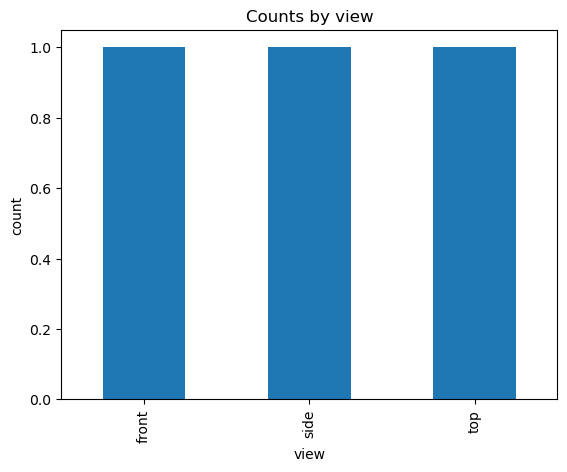

In [4]:
# Preview pairs.csv and make a tiny plot
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data/pairs.csv")
display(df.head())
print("Rows:", len(df))

# simple count by view
counts = df["view"].value_counts()
plt.figure()
counts.plot(kind="bar")  # matplotlib will handle default style; no seaborn
plt.title("Counts by view")
plt.xlabel("view")
plt.ylabel("count")
plt.show()
